<a href="https://colab.research.google.com/github/hufsaim/T10402201/blob/master/ch08/rnn_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementation of Recurrent Neural Networks
- https://d2l.ai/chapter_recurrent-neural-networks/rnn-scratch.html
- Google Colab을 사용하는 경우 런타임 유형을 GPU로 변경하여 학습을 진행합니다.


In [1]:
!nvidia-smi

Wed May 12 11:25:40 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    30W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install d2l

In [3]:
%matplotlib inline
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

- d2l에서 제공하는 함수로 time machine textdata에 대한 dataloader와 vocab.을 가져옵니다.

In [4]:
batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)
for X, y in train_iter:
  print(X)
  print(y)
  break;

tensor([[ 9,  5,  6,  ..., 12, 12,  2],
        [14, 21, 21,  ...,  1,  7, 14],
        [16,  7, 10,  ..., 11, 13,  5],
        ...,
        [ 1,  9,  2,  ...,  2,  1,  9],
        [ 2,  1,  8,  ..., 20, 12,  5],
        [ 3,  9,  2,  ..., 11,  7, 17]])
tensor([[ 5,  6,  2,  ..., 12,  2, 10],
        [21, 21, 12,  ...,  7, 14, 10],
        [ 7, 10,  2,  ..., 13,  5, 10],
        ...,
        [ 9,  2,  1,  ...,  1,  9,  2],
        [ 1,  8, 14,  ..., 12,  5, 15],
        [ 9,  2,  6,  ...,  7, 17,  6]])


In [5]:
len(vocab)

28

- 학습에 사용할 hidden layer가 1개인 RNN model을 만들어 봅니다.

In [6]:
class RNNModelScratch:  
    """A RNN Model implemented from scratch."""
    def __init__(self, vocab_size, num_hiddens, device, get_params,
                 init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn

    def __call__(self, X, state):
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        return self.forward_fn(X, state, self.params)

    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)

In [7]:
def rnn(inputs, state, params):
    # Here `inputs` shape: (`num_steps`, `batch_size`, `vocab_size`)
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    # Shape of `X`: (`batch_size`, `vocab_size`)
    for X in inputs:
        H = torch.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h)
        Y = torch.mm(H, W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)

def init_rnn_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device),)    

In [8]:
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01

    # Hidden layer parameters
    W_xh = normal((num_inputs, num_hiddens))
    W_hh = normal((num_hiddens, num_hiddens))
    b_h = torch.zeros(num_hiddens, device=device)
    # Output layer parameters
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # Attach gradients
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params
    

- 예측 및 훈련에 활용할 함수들을 정의합니다. 
- grad_clipping은 sequence의 길이가 길어질 때에 발생할 수 있는 vanishing or exploding을 줄여주기 위한 장치입니다.


In [9]:
def predict_ch8(prefix, num_preds, net, vocab, device):  
    """Generate new characters following the `prefix`."""
    state = net.begin_state(batch_size=1, device=device)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape(
        (1, 1))
    for y in prefix[1:]:  # Warm-up period
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds):  # Predict `num_preds` steps
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

In [10]:
def grad_clipping(net, theta):  
    """Clip the gradient."""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad**2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

In [11]:
def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    """Train a net within one epoch (defined in Chapter 8)."""
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)  # Sum of training loss, no. of tokens
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # Initialize `state` when either it is the first iteration or
            # using random sampling
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
          for s in state:
            s.detach_()

        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        l.backward()
        grad_clipping(net, 1)
        updater(batch_size=1)
        metric.add(l * y.numel(), y.numel())
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

In [12]:
def train_ch8(net, train_iter, vocab, lr, num_epochs, device,
              use_random_iter=False):
    """Train a model (defined in Chapter 8)."""
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    # Initialize
    updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)
    # Train and predict
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(net, train_iter, loss, updater, device,
                                     use_random_iter)
        if (epoch + 1) % 50 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    print(f'perplexity {ppl:.1f}, {speed:.1f} tokens/sec on {str(device)}')
    print(predict('time traveller'))


- 학습에 활용할 model을 생성하고, model의 출력이 가지는 shape을 확인합니다.

In [13]:
num_hiddens = 512
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                      init_rnn_state, rnn)
state = net.begin_state(X.shape[0], d2l.try_gpu())
Y, new_state = net(X.to(d2l.try_gpu()), state)
Y.shape, len(new_state), new_state[0].shape

(torch.Size([1120, 28]), 1, torch.Size([32, 512]))

- 학습이 진행되지 않은 상태에서 prediction을 진행하면, 의미없는 글자들을 출력할 것 입니다.

In [14]:
predict_ch8('time traveller ', 50, net, vocab, d2l.try_gpu())


'time traveller nxayrwqhts<unk>nxayrwqhts<unk>nxayrwqhts<unk>nxayrwqhts<unk>nxayrw'

- 학습을 진행하면서 'time traveller'에 대한 예측이 어떻게 변화해가는 지를 살펴봅니다.

perplexity 1.3, 95187.2 tokens/sec on cuda:0
time traveller held in his hand was a glitteringmetallic framewo


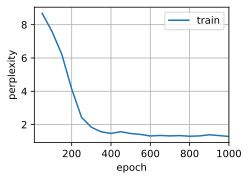

In [15]:
num_epochs, lr = 1000, 1
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu(), use_random_iter = True)

- 임의의 단어를 입력으로 하였을 때, 예측이 어떻게 나오는지를 관찰해 봅니다. 

In [16]:
predict_ch8('banana is',102,net,vocab,d2l.try_gpu())

'banana is at sy eatiry me said the very young man just thinkone might invest all one s money leave it to accumu'